## HW-3: Problem 2

This code is used to solve Problem 2 in HW 3. 

In [85]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt

In [70]:
# Load the data
df = pd.read_csv('../data/Data_Lecture_3.csv', index_col=0, parse_dates=True)
df.head()

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XYL,YUM,ZBH,ZION,MKT,SMB,HML,RF,CPI,IndProd
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,8.965403,5.617027,1.604202,-15.559467,4.947367,7.786493,7.793523,0.397299,3.687699,4.077818,...,3.016765,-1.707844,11.253543,8.592044,5.57,0.39,0.95,0.0,-0.281588,0.405392
2013-02-28,-7.655023,-6.136895,3.763957,-2.577849,4.403527,-0.265997,3.378099,3.837650,4.302967,11.621178,...,-1.140784,0.828099,0.481413,3.537714,1.29,-0.45,0.03,0.0,-0.209016,-0.172034
2013-03-31,1.459880,23.395607,8.016544,0.285049,8.621657,4.428448,2.142036,10.162677,2.769777,5.703634,...,0.217944,9.408769,0.615394,3.419136,4.03,0.78,-0.29,0.0,0.041407,0.109350
2013-04-30,-1.270848,-0.413346,1.477238,0.027105,5.059334,4.805337,7.999121,3.533298,-5.527490,0.620661,...,0.687039,-4.955616,1.621978,-1.491662,1.55,-2.42,0.63,0.0,0.237758,0.203532
2013-05-31,9.236622,3.887928,-2.853882,2.224061,0.311349,-0.679443,0.819326,-4.933379,5.058140,-4.613367,...,1.797858,-0.544640,2.658907,13.259207,2.80,1.67,2.60,0.0,0.195554,-0.427080


In [24]:
# Load CPI (costumer price index) 
# and IP (industrial production)
cpi = df['CPI']
ip = df['IndProd']

In [30]:
# Create the lagged variables (t-1) 
# for the regression model
cpi_1 = cpi.shift(periods=-1)
cpi_comb = pd.concat([cpi, cpi_1.rename('CPI_1')], axis=1)
ip_1 = ip.shift(periods=-1)
ip_comb = pd.concat([ip, ip_1.rename('IndProd_1')], axis=1)
ip_comb.head()

,IndProd,IndProd_1
Date,,
2013-01-31,0.405392,-0.172034
2013-02-28,-0.172034,0.109350
2013-03-31,0.109350,0.203532
2013-04-30,0.203532,-0.427080
2013-05-31,-0.427080,0.658091


For CPI and IP, we run the following regressions:

$CPI_t = \beta_0 + \beta_1 CPI_{t-1}$ 

$IP_t = \beta_0 + \beta_1 IP_{t-1}$

In [49]:
# CPI regression
model_cpi = sm.ols('CPI~CPI_1', data=cpi_comb).fit()
beta_cpi_0 = model_cpi.params['Intercept']
beta_cpi_1 = model_cpi.params['CPI_1']

# IP regression
model_ip = sm.ols('IndProd~IndProd_1', data=ip_comb).fit()
beta_ip_0 = model_ip.params['Intercept']
beta_ip_1 = model_ip.params['IndProd_1']

In [104]:
# Time series for CPI and IP:
# The difference between the forecast and the actual return
f_cpi = model_cpi.resid.rename('F_CPI')
f_ip = model_ip.resid.rename('F_IP')

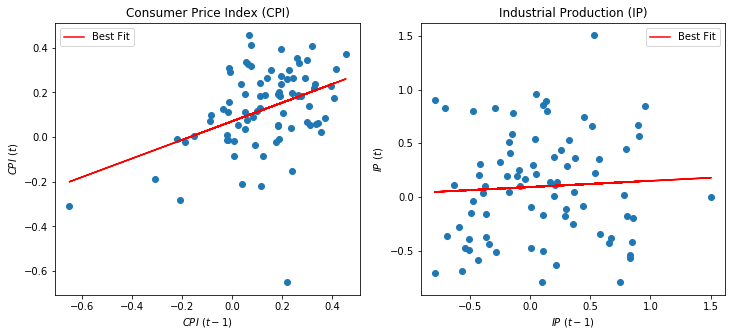

In [107]:
# Plot regression results for CPI and IP
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(cpi_comb['CPI_1'], cpi_comb['CPI'], 'o')
ax1.plot(cpi_comb['CPI_1'], beta_cpi_0 + beta_cpi_1*cpi_comb['CPI_1'], 'r', label='Best Fit')
ax1.set_xlabel(r'$CPI\ (t-1)$')
ax1.set_ylabel(r'$CPI\ (t)$')
ax1.set_title('Consumer Price Index (CPI)')
ax1.legend()

ax2.plot(ip_comb['IndProd_1'], ip_comb['IndProd'], 'o')
ax2.plot(ip_comb['IndProd_1'], beta_ip_0 + beta_ip_1*ip_comb['IndProd_1'], 'r', label='Best Fit')
ax2.set_xlabel(r'$IP\ (t-1)$')
ax2.set_ylabel(r'$IP\ (t)$')
ax2.set_title('Industrial Production (IP)')
ax2.legend()

fig.savefig('../output/cpi_ip_regression.pdf')



In [82]:
# Get excess returns of Apple
ret_excess_aapl = (df['AAPL'] - df['RF']).rename('AAPL_E')
comb_df = pd.concat([ret_excess_aapl, f_cpi, f_ip], axis=1)
comb_df.head()

,AAPL_E,F_CPI,F_IP
Date,,,
2013-01-31,-15.559467,-0.265428,0.322638
2013-02-28,-2.577849,-0.297135,-0.270980
2013-03-31,0.285049,-0.128474,0.004985
2013-04-30,0.027105,0.085452,0.135454
2013-05-31,2.224061,0.025388,-0.557601


Estimate the time series factors for IP and CPI using Apple's excess returns:

$R_{i,t}^e = b_{i,CPI}F_{CPI,t} + b_{i,IP}F_{IP,t}$ where $F_{CPI,t}$ and $F_{IP,t}$ denote the time series for two factors: CPI and IP, respectively.

In [83]:
# Run the regression
model = sm.ols('AAPL_E ~ F_CPI + F_IP', data=comb_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AAPL_E   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.365
Date:                Sun, 09 Feb 2020   Prob (F-statistic):              0.261
Time:                        22:41:53   Log-Likelihood:                -276.70
No. Observations:                  81   AIC:                             559.4
Df Residuals:                      78   BIC:                             566.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4354      0.834      1.721      0.089      -0.225       3.096
F_CPI         -2.7057      4.948     -0.547      0.586     -12.556       7.144
F_IP           2.6849      1.693      1.586      0.117      -0.685       6.055
==============================================================================
Omnibus:                        5.564   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.001
Skew:                          -0.597   Prob(JB):                       0.0820
Kurtosis:                       3.236   Cond. No.                         5.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
# Get model results
intercept = model.params['Intercept']
coef_cpi = model.params['F_CPI']
coef_ip = model.params['F_IP']

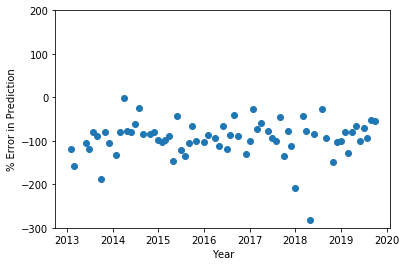

In [126]:
# Plot the results
prediction = intercept + coef_cpi*f_cpi + coef_ip*f_ip
err = (prediction-comb_df['AAPL_E'])*100/comb_df['AAPL_E']
fig, ax = plt.subplots(1,1)
ax.plot(err, 'o')
ax.set_ylim(-300,200)
ax.set_xlabel('Year')
ax.set_ylabel('% Error in Prediction')
fig.savefig('../output/percent_error_pred.pdf')